In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from d2l import torch as d2l
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    # def __getitem__(self, idx):
    #     feature = torch.tensor(self.features[idx], dtype=torch.float)
    #     label = torch.tensor(self.labels[idx], dtype=torch.float)
    #     return feature, label
    def __getitem__(self, idx):
        feature = self.features[idx].clone().detach().float()
        label = self.labels[idx].clone().detach().float()
        return feature, label

T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
print(x.shape)

torch.Size([1000])


In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))
print(features.shape, labels.shape)

torch.Size([996, 4]) torch.Size([996, 1])


In [3]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
# train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)
train_iter = DataLoader(MyDataset(features[:n_train], labels[:n_train]), batch_size, shuffle=True)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none') #平方误差。注意：MSELoss不会除以2

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss {l.mean():.6f}')

In [5]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss 0.146227
epoch 2, loss 0.052311
epoch 3, loss 0.046469
epoch 4, loss 0.033694
epoch 5, loss 0.068302


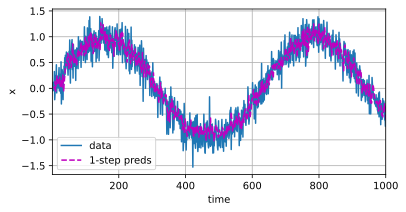

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

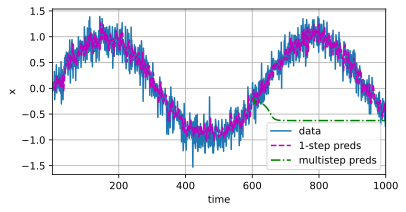

In [13]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))